In [1]:
from DELCgen import *
import scipy.stats as st
import matplotlib.pyplot as plt 
from constants import *
from scipy.interpolate import interp1d
import naima
import astropy.units as u
import subroutines as sub
import os

This piece of code runs a simple simulation where a CR population is injected and evolved with a variable jet. We need to define the maximum rigidity which is related to the jet power
$$
R_{\mathrm{max}} = 10^{19}~V\left(\frac{Q_j}{10^{44}~\mathrm{erg~s}^{-1}}\right)^{1/2}
    \left(\frac{\eta}{0.1}\right)
    \left(\frac{u}{0.1c}\right).
$$

the "power threshold" is the inverse expression with $Q_j$ as the subject. We use an input power spectral density (PSD) and jet power probability distribution function (PDF) to generate a time series for the jet power for a given set of PSD and PDF parameters. To do this, we use the method described by Emmanolopoulous et al. and implemented in python by Connolly. The PSD is implemented as a bending power-law model of the form 

$$\mathrm{PSD}(\nu,\bar{Q},\nu_c) = A(\bar{Q}) \frac{\nu^{-\alpha_{\mathrm{low}}}}
               {1+(\nu/\nu_c)^{\alpha_{\mathrm{high}}-\alpha_{\mathrm{low}}}}$$
               
               
We set $\alpha_{\mathrm{low}} = 1$ for a pink noise spectrum, $\alpha_{\mathrm{high}} = 10$ so as to suppress high frequency variability, and $\nu_c = 1$Myr, roughly equal to the light travel time, $\tau_c=L/c$, along a $L=300$kpc jet. The acceleration time relates to $\tau_c$ by $\tau_\mathrm{acc}/\tau_c \approx (Rc)/(uL)$, since the highest energy particles reach Larmor radii comparable to $(u/c)R$ (Hillas criterion). The longest CR acceleration time is therefore shorter than the light travel time along the jet for any fast, long and thin jet ($u/c>R/L$). 

In [2]:
def power_threshold(rigidity, v_over_c=0.1, eta=0.1):
    power = (0.1 / eta) * (rigidity / 1e19)**2 * (0.1/v_over_c) * 1e44
    return power 

def max_energy(power, v_over_c=0.1, eta=0.1):
    return 1e19*np.sqrt( (power/1e44) * (v_over_c/0.1))

def get_lc(lognorm_params, PSD_params, tbin, Age):
    # Simulation params
    # let's do everything in units of kyr
    # run for 100 Myr (1e5 kyr) in bins of 0.1 Myr
    #lognorm_params = (1.5,0,np.exp(1.5))
    RedNoiseL,RandomSeed,aliasTbin = 100,12,100
    N = Age / tbin

    lc = Simulate_DE_Lightcurve(BendingPL, PSD_params,st.lognorm,lognorm_params,
                                    RedNoiseL=RedNoiseL,aliasTbin=aliasTbin,randomSeed=RandomSeed,LClength=Age, tbin=tbin)

    return (lc)

Now we've set up the basic functions. Let's initialise our parameters for the variable jet history and initialise the tau_loss dictionary which stores the loss times for the different species (calculated using CRPropa).  

In [3]:
# set up light curve. pl_index of 1 means red noise.
pl_index = 1

# bend the power law at 1 Myr (1e-3 kyr^-1) and steeply decay it beyond that with index 10. 
# A,v_bend,a_low,a_high,c = 1, 1e-3, pl_index, 10, 1
PSD_params = (1, 1e-3, pl_index, 10, 1)
lognorm_params = (1.5,0,np.exp(1.5))
tbin = 100    # 100 kyr 
age = 1000

# Age of 1000 means 100 Myr
# paramaters for lc are lognorm parameters, PSD parameters, tbin and Age (Age is really number of points)
lc = get_lc(lognorm_params, PSD_params, tbin, age)

# time is in kyr, so convert to Myr
times = np.arange(0,age*tbin,tbin) 

# get losses 
elems = ["H", "He", "N", "Fe"]
tau_loss = dict()
energies = np.logspace(6,14.5,num=3000)
for i in range(len(elems)):
    tau_loss[elems[i]] = sub.Losses(elems[i])
    tau_loss[elems[i]].interpol(energies)

Set up arrays to loop over. flux_scales contains the normalisations of our jet power $(\bar{Q})$.
This is actually the median of the distribution, or the mean in log space.
betas is the spectral index of the injected spectrum ($\beta$).

In [4]:
# flux_scales contains the normalisations of our jet power 
# actually the median of the distribution, or the mean in log space.
# betas is the spectral index of the injected spectrum 
flux_scales = np.logspace(43,45,num=10)
betas = np.arange(2,3,0.1)
betas = [2,2.3,2.7]
flux_scales = [1e43,1e44]
betas = [2]
flux_scales = [1e43]

# arrays to store gamma ray and UHECR luminosities
lgammas = np.zeros((len(flux_scales), len(betas)))
lcrs = np.zeros((len(flux_scales), len(betas)))

Let's loop over the flux scales and the spectral indices. The method is as follows. For each value of $\bar{Q}$ and $\beta$, we evolve a CR distribution for each ionic species numerically using the following equation,

$$
    \frac{dn_i(E)}{dt} = S(E/Z_i, f_i, t) - \frac{n(E)}{\tau_\mathrm{esc} (E/Z_i)} - \frac{n(E)}{\tau_\mathrm{loss} (E, Z_i)}.
$$

The total differential CR spectrum is then just $n(E,t)=\sum_i n_i(E,t)f_i$. We follow, e.g., Eichmann et al. 2018 in using a power-law for the injection term $S({\cal R}_i, f_i, t)$ with a sharp cutoff, given by

$$
    S(E/Z_i, f_i, t) = 
    f_i \eta Q_j(t)~\nu_i
    \left(\frac{{\cal R}}{{\cal R}_0}\right)^{-\beta}~f_{\mathrm{cut}}(R_{\mathrm{max}}).
    % f_\mathrm{cut}
$$

where $\nu_i$ is the normalisation of the distribution and is given by $\nu_i=1.0/[\ln({\cal R}_\mathrm{max}(t)/{\cal R}_0]$ for $\beta=2$ and $\nu_i=(2-\beta)/[({\cal R}_\mathrm{max}/{\cal R}_0)^{(2-\beta)}-1]$ for $\beta > 2$.  We set ${\cal R}_\mathrm{max}$ according to the maximum rigidity condition, ${\cal R}_0=1\mathrm{GV}$. 

In [5]:
for i_flux, flux_scale in enumerate(flux_scales):

    # normalise the light curve
    flux = lc.flux * flux_scale 
    
    # loop over spectral indices
    for i_beta, BETA in enumerate(betas):
    
        # elemental "abundances" - really injection fractions 
        # this is roughly solar, but should probably be top heavy since it is easier to inject heavy ions, generally
        #frac_elem = np.array([1.0,0.1,1e-4,3.16e-05])
        frac_elem = np.array([1.0,0,0,0])
        
        # normalise! 
        frac_elem /= np.sum(frac_elem)
        
        # charges 
        z_elem = np.array([1,2,7,26])
        
        # array to store the current CR spectrum for each ion
        ncr = np.zeros( (len(z_elem),len(energies)) )
        
        # arrays to store the stored and escaping CRs for every time bin and every ion
        ncr_time = np.zeros( (len(z_elem),len(flux),len(energies)) )
        escaping_time = np.zeros( (len(z_elem),len(flux),len(energies)) )

        # do you want to plot everything? 
        plot_all = False

        # R0 is the injection rigidity, let's use 10 Mev
        R0 = 1e7
        
        # Zbar is the average charge 
        Zbar = np.sum(frac_elem * z_elem)
    
        lgamma = np.zeros_like(flux)
        
        for i in range(len(flux)):
            
            print (i)

            # get the maximum rigidity from the power requirement
            #Rmax = max_energy(flux[i], v_over_c=0.5)
            Rmax = 1e14

            # normalisation of cosmic ray distribution depends on BETA 
            if BETA == 2:
                dynamic = 1.0/(np.log(Rmax/R0))
            else:
                dynamic = (2 - BETA) / ((Rmax/R0)**(2-BETA)-1.0)
                
            # put 10% of jet energy into CRs, store in eV units 
            Q0 = 0.1 * flux[i] / EV2ERGS

            # get the time step - IMPROVE 
            delta_t = tbin * 1000.0 * YR
            
            if plot_all:
                # this plots the lightcurve 
                fig, ax2, ax3 = sub.init_lc_plot(lc.time[:i+1] / 1000.0, flux[:i+1])
            
            lcr = 0.0

            for j, frac in enumerate(frac_elem):

                rigidities = energies / z_elem[j]

                # escape time is 1e7 YR for 10EV rigidity 
                #escape_time = (1e19 / rigidities) * 1e7 * YR 
                cooling_time = 12.53 * 1e9 * YR * (1e9 / rigidities)

                # need to get things in the right units
                nu_i = frac / z_elem[j] / R0**2 * dynamic / Zbar

                # add_on is the injection term 
                add_on = nu_i * Q0 * ((rigidities / R0)**-BETA)

                # beyond the cutoff we set injected term to 0
                add_on[(rigidities>=Rmax)] = 0.0
                add_on[(rigidities<=R0)] = 0.0

                # number of escaping CRs 
                escaping = ncr[j] / cooling_time

                # loss rate 
                loss =  ncr[j] / (tau_loss[elems[j]].total_interpol *  1e6 * YR)

                # this is dn/dt for each energy 
                change = (add_on - escaping - loss)*delta_t

                # change the ncr distribution
                ncr[j] += change
                ncr[j][(ncr[j]<0)] = 0

                #if j == 0:
                ncr_time[j,i,:] = ncr[j]
                escaping_time[j,i,:] = escaping

                # cutoff for UHECRs (60 EeV)
                select = (energies > 6e19)

                # store the UHECR luminosity 
                lcr += np.fabs(np.trapz(energies[select] * EV2ERGS, energies[select] * escaping[select]))
                
                if j == 0:
                    #lcrtot = np.trapz(energies * EV2ERGS, energies * escaping)
                    all_lobe = np.trapz(energies * EV2ERGS, energies * ncr[j])

                if plot_all and j == 0 and i > 0:
                    sub.plot_spectra(fig, ax2, ax3, rigidities * z_elem[j], ncr[j], escaping*delta_t, 0, xlims = (1e9,1e14))
 
            if plot_all:
                os.system("mkdir electron_spectra/beta{:.1f}q{:.1f}".format(BETA, np.log10(flux_scale)))
                plt.savefig("electron_spectra/beta{:.1f}q{:.1f}/spectra{:03d}.png".format(BETA, np.log10(flux_scale), i))
                plt.close("all")
                
        np.save("electron_array_saves/escaping_beta{:.1f}q{:.1f}.npy".format(BETA, np.log10(flux_scale)), escaping_time)
        np.save("electron_array_saves/ncr_beta{:.1f}q{:.1f}.npy".format(BETA, np.log10(flux_scale)), ncr_time)
        
        # get approximate gamma ray luminosity around 10 GeV
        select = (energies > 1e10) * (energies < 2e10)
        my_lgamma = np.fabs(np.trapz(energies * EV2ERGS, energies*ncr[0]))
        
        # distance to Cen A
        distance = 3.7 * PARSEC * 1e6
        lgammas[i_flux,i_beta] = my_lgamma * 1e-4 * 4.5e-26 * 0.5 * C / 4.0 / PI / distance / distance
        lcrs[i_flux,i_beta] = lcr
        
        print ("BETA {:.1f} median lum {:8.4e} mean lum {:8.4e} UHECR LUM: {:8.4e} {:8.4e}".format(BETA, flux_scale, np.mean(flux), lcr, lgammas[i_flux,i_beta]))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Now let's make a movie with ffmpeg (pretty hacky this)

In [6]:
import os
os.system("ffmpeg -y -i electron_spectra/beta2.0q43.0/spectra%3d.png -r 6 electron_spectra_over_time.mp4")
os.system("ffmpeg -y -i electron_spectra/beta2.0q43.0/spectra%3d.png -r 6 electron_spectra_over_time.gif")
import time
time.sleep(3)

import io
import base64
from IPython.display import HTML

video = io.open('electron_spectra_over_time.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

from IPython.display import Video

Video("electron_spectra_over_time.mp4")

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(4, 3000) (4, 1000, 3000)
[1764 2470 2646]
10.999666555518505
13.000666888962987
13.49949983327776


[]

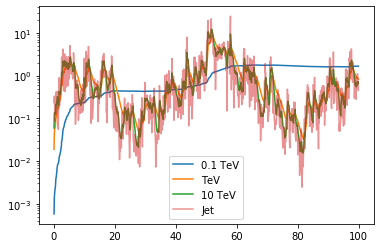

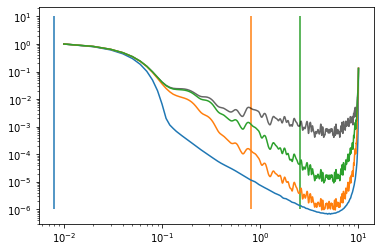

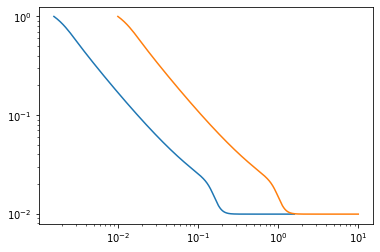

In [7]:
from py_plot_util import smooth
rms = np.std(ncr_time, axis=1) / np.mean(ncr_time, axis=1)
#rms = np.std(ncr_time[0]*energies*energies, axis=0)
print (rms.shape, ncr_time.shape)

from scipy.fftpack import fft

reference_energies = [11,13,13.5]
indices = np.zeros(3)
#for i, r in enumerate(reference_energies):
indices = np.array([np.argmin( np.fabs(np.log10(energies) - r)) for r in reference_energies])

print (indices)
#indices = [-200,-700,-1000]
#plt.plot(np.arange(0,100,0.1), ncr_time[0,:,-200])
#plt.plot(np.arange(0,100,0.1), ncr_time[0,:,-100])
fig1 = plt.figure()
labels = ["0.1 TeV", "TeV", "10 TeV"]
for ii, i in enumerate(indices):
    plt.plot(np.arange(0,100,0.1), ncr_time[0,:,i]/np.mean(ncr_time[0,:,i]), label = labels[ii])
    
plt.plot(np.arange(0,100,0.1), flux/np.mean(flux), alpha=0.5, label="Jet")
plt.legend()
plt.semilogy()
# plt.xlabel("time (Myr)")
# plt.ylabel("$n(E)$ or jet power")
# plt.savefig("synchrotron_lc.png", dpi=300)

age = 1000
Freq = np.arange(1, age+1) / (age*tbin/1000.0)

fig2 = plt.figure()

ff = fft(flux)
psd_lc = np.absolute(ff)**2.0 
psd_lc /= np.max(psd_lc)
plt.plot(Freq, smooth(psd_lc/np.max(psd_lc)), c="k", alpha=0.6)

for ii, i in enumerate(indices):
    ff = fft(ncr_time[0,:,i])
    psd = np.absolute(ff)**2.0
    plt.plot(Freq, smooth(psd/np.max(psd)), color="C" + str(ii), label=labels[ii])
    cooling_time = 12.53 * (1e9 / energies[i]) * 1e3
    plt.vlines([1/cooling_time], 1e-6,10, color="C" + str(ii))
    print (np.log10(energies[i]))
    



ff = fft(flux)
psd = np.absolute(ff)**2.0
#plt.plot(Freq, smooth(psd/np.max(psd)))
psd_lc2 = BendingPL(Freq, 1, 1, 1, 10, 1)

#plt.plot(Freq, smooth(psd_lc2/np.max(psd_lc2)))
ff = np.logspace(-1,4,1000)
#plt.plot(Freq,1.0/Freq, ls="--", c="k")
plt.loglog()
#plt.xlim(0.1,1e4)
#plt.ylim(1e-5,1)

plt.figure()
age = 1e3
Freq = np.arange(1, age+1, 0.1) / (age*tbin/1000.0)
psd_lc2 = BendingPL(Freq, 1, 1, 1, 10, 1)
plt.plot(Freq/2.0/np.pi, smooth(psd_lc2/np.max(psd_lc2)))
plt.plot(Freq, smooth(psd_lc2/np.max(psd_lc2)))
plt.loglog()



[1.53668833 0.58304894 0.44671059 ... 1.01806462 0.90608426 1.03041835]


NameError: name 'duration_s' is not defined

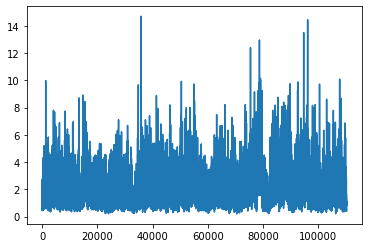

In [8]:
import numpy as np
from scipy.io.wavfile import write

sps =44100//2
duration = 5.0
Age = int(sps * duration)
pl_index = 1
PSD_params = (1, 1e20, pl_index, pl_index, 1)
lognorm_params = (0.5,0,np.exp(0.5))
lc = get_lc(lognorm_params, PSD_params, tbin, Age)
flux = lc.flux

plt.plot(flux)
print (flux)
# Samples per second
sps =44100

# Frequency / pitch of the sine wave
freq_hz = 440.0


# NumpPy magic
each_sample_number = np.arange(duration_s * sps)
waveform = np.sin(2 * np.pi * each_sample_number * freq_hz / sps)
waveform_quiet = waveform * 0.3
waveform_integers = np.int16(waveform_quiet * 32767)
print (waveform_integers)
# Write the .wav file
#write('first_sine_wave.wav', sps, waveform_integers)
wave = np.int16( (flux/np.max(flux)) * 32767)
#wave = np.int16((flux/1e45) * 32767)
write('linear.wav', sps, wave)
print (wave, sps)

#plt.plot(wave)


In [ ]:
import naima 

print (energies[0]/1e6, energies[-1]/1e14)
print (energies.shape)
def get_synchrotron_spectrum(energies, ncr, B=100.0, Epmin=1e6):
    Epmax = energies[-1]
    interp_func = interp1d(energies * u.eV, ncr)
    def PD(my_energy):
        try: 
            f = interp_func(energies)
        except ValueError:
            f = 0.0
        return (f * u.Unit('1/eV'))

    ECPL = PD
    spectrum_energy = energies * u.eV
    nepd = len(spectrum_energy) / np.log10(spectrum_energy[-1]/spectrum_energy[0])
    SYN = naima.models.Synchrotron(ECPL, B=B*u.uG, nEpd=nepd, Epmin = Epmin * u.eV, Epmax=Epmax * u.eV)
    sed = SYN.sed(spectrum_energy, distance=3.7*u.Mpc)
    return SYN

ncr = np.load("electron_array_saves/ncr_beta{:.1f}q{:.1f}.npy".format(BETA, np.log10(flux_scale)))
nn = ncr[0,-1,:]
sync = get_synchrotron_spectrum(energies, ncr, B=1.0)
sed = sync.sed(spectrum_energy, distance=3.7*u.Mpc)

In [ ]:
import naima
import astropy.units as u
#ECPL
#ncr = np.load("electron_array_saves/ncr_beta{:.1f}q{:.1f}.npy".format(2, 43))
ncr = ncr_time[0,-10,:]
plt.loglog(energies, ncr)

In [ ]:
from scipy import integrate,special
import numpy as np 
from constants import *

def F(x):
    """ This is F(x) defined in equation 6.31c in R&L.
        
        F(x) = x*int(K_5/3(x)dx) where the integral goes from x to infinity.

        for some reason, special.kv(5/3,1e10) is NaN, not 0 ???
        for now, just clip the function above 1e5 to be 0. 
        
        This function can be evaluated in mathematica using the following command
            F[x_] := N[x*Integrate[BesselK[5/3, y], {y, x, Infinity}]]
        From mathematica, we find that
                  x         F(x)
              ----- ------------
                0.1     0.818186
                  1     0.651423
                 10  0.000192238
                100            0
        Comparing our function to the Mathematica integral, we find
            >>> np.allclose(Synchrotron.F([0.1,1,10,100]), [0.818186, 0.651423, 0.000192238,0], rtol=1e-4, atol=1e-4)
            True
        Note, this function is _F so that the docstring will get executed.
    """
    if x > 1e5: 
        return 0
    return x*integrate.quad(lambda j: special.kv(5./3,j),x,np.inf)[0]

def psynch(energy, nu, Bfield):
    sinalpha = 1.0 / 3.0
    gamma = energy / MELEC / C / C
    nu_c = 3.0 * gamma * gamma * E * Bfield * sinalpha / MELEC / C / 2.0 
    term1 = np.sqrt(3)
    term2 = E*E*E * Bfield * sinalpha / MELEC / C / C 
    term3 = F(nu/nu_c)
    return term1 * term2 * term3 

def Ptot(frequencies, energies, ncr, Bfield):
    pnu = np.zeros_like(frequencies)
    for inu, nu in enumerate(frequencies):
        print (inu)
        power = np.array(list(map(lambda x: psynch(x, nu, Bfield), energies)))
        #power = map(psynch(energy, nu, Bfield)
        #power = np.array([psynch(energy, nu, Bfield) for energy in energies])
        pnu[inu] = np.trapz(energies, ncr * power)
    return pnu

Bfield = 1e-6
ncr = np.load("electron_array_saves/ncr_beta{:.1f}q{:.1f}.npy".format(2.0, 43))
ncr = ncr[0,-1,:]
nu = np.logspace(6,14,num=100)
power = Ptot(nu, energies, ncr, Bfield)

In [ ]:
plt.loglog(nu, power)